This code is heavily referenced by: 
https://github.com/rohan-paul/MachineLearning-DeepLearning-Code-for-my-YouTube-Channel/blob/master/NLP/Fine_Tuning_HuggingFace_Transformer_BERT_Yelp_Customer_Review_Predictions/Fine_Tuning_Transformer_BERT_Customer_Review.ipynb

In [1]:
!pip install transformers tokenizer -q

In [1]:
#imports
import numpy as np # linear algebra
import pandas as pd # data processing CSV file


# import matplotlib.pyplot as plt # visualising data
# import seaborn as sns # visualising statistical data
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# %matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

In [2]:
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim

from collections import defaultdict

MAX_LEN = 512
BATCH_SIZE = 16

RANDOM_SEED = 32
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

pre_trained_model_ckpt='bert-base-uncased'


# CONVERTING DATASET SO THAT IT CAN BE FED INTO THE MODEL
class ReviewDataset(Dataset):
    def __init__(self, text, target, tokenizer, max_len):
        self.text = text
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item]) 
        target = self.target[item]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            max_length = self.max_len,
            return_token_type_ids = True,
            return_attention_mask = True,
            truncation = True,
            pad_to_max_length = True,
            return_tensors = 'pt',)

        output = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }
        
        return output


pre_trained_model_ckpt = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pre_trained_model_ckpt)

from transformers import DataCollatorWithPadding
collator = DataCollatorWithPadding(tokenizer=tokenizer,padding = 'longest')

def create_data_loader(df, tokenizer, max_len = MAX_LEN, batch_size = BATCH_SIZE ):
    ds = ReviewDataset(
        text=df.text.to_list(), 
        target = df.humor.to_list(),
        tokenizer=tokenizer,
        max_len=max_len,

    )

    return DataLoader(ds, batch_size=batch_size, collate_fn=collator ) #formats the data such that it is fed in shuffled iterations



# ADDITION CLASSIFIER ON TOP OF BERT BASE
class SentimentClassifier(nn.Module):
    """
    Sentiment classification model based on BERT.

    Args:
        n_classes (int): Number of classes for sentiment classification.

    """
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__() #calls superinit first to ensure superclass('nn.module') is initialised first
        self.bert = BertModel.from_pretrained(pre_trained_model_ckpt,return_dict=False)
        self.drop = nn.Dropout(p = 0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the sentiment classifier model.

        Args:
            input_ids (torch.Tensor): Input tensor of shape (batch_size, sequence_length).
            attention_mask (torch.Tensor): Attention mask tensor of shape (batch_size, sequence_length).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, n_classes).

        """
        _, pooled_output = self.bert( #inputs are passed through bert as a base model and outputs are returnd under pooled_output
            input_ids = input_ids,
            attention_mask = attention_mask
        )
        output = self.drop(pooled_output) #dropout layer is applied here -- is a neural network used to prevent overfitting which is used on top of the base model
        return self.out(output)





#EVAL FUNCTIONS
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    """
    Trains the given model using the provided data loader and optimizer.

    Args:
        model (torch.nn.Module): Model to train.
        data_loader (DataLoader): DataLoader providing the training data.
        loss_fn: Loss function to optimize.
        optimizer: Optimizer for updating the model's parameters.
        device: Device to use for training.
        scheduler: Learning rate scheduler.
        n_examples (int): Total number of training examples.

    Returns:
        float: Accuracy of the model on the training data.
        float: Average training loss.

    """
    model=model.train()
    losses = []
    correct_predictions = 0

    """  iterate over the batches provided by the data loader. Within each iteration, the batch tensors are moved to the appropriate device. The model performs a forward pass on the input tensors, and the predicted labels are obtained by taking the maximum value along the appropriate dimension. """
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets).cpu()

        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions/n_examples, np.mean(losses) # gradient clipping


def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad(): # disable gradient computation of loss function
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            _,preds = torch.max(outputs, dim = 1)

            loss = loss_fn(outputs, targets.detach())
            correct_predictions += torch.sum(preds == targets).cpu()
            losses.append(loss.item())
    return correct_predictions/n_examples, np.mean(losses)

# Model Evaluation on test_data_loader
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    prediction_probs = []
    real_values = []
    inputs = []

    with torch.no_grad():
        for d in data_loader:
#             texts = d["text"].to(device)
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim =1)
#             review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)
            inputs.extend(input_ids) ## rmb to add a line to return this... omg

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    inputs = torch.stack(inputs).cpu()
    return predictions, prediction_probs, real_values #, review_texts

In [3]:
#please upload the dataset file before running
data = '/Users/hanyen/Desktop/centad/models/dataset.csv' # raw dataset
df = pd.DataFrame(pd.read_csv(data,nrows=10000))
# df['humor'] = np.where(df['humor'],1,0)

df.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


In [1]:
import seaborn as sns
sns.set(style='whitegrid',palette='muted',font_scale=1.2)
sns.set_palette(sns.color_palette('Paired'))
import matplotlib.pyplot as plt
# plotting

ModuleNotFoundError: No module named 'seaborn'

Text(0.5, 0, 'Token Count')

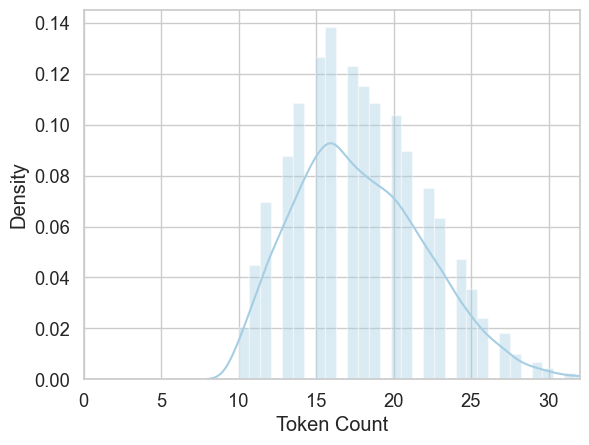

In [5]:
# look at timestamp 16:27
token_length_list = []
for txt in df.text:
  tokens = tokenizer.encode(txt, truncation=True, max_length=512)
  token_length_list.append(len(tokens))

sns.distplot(token_length_list)
plt.xlim([0,32])
plt.xlabel('Token Count')

In [6]:
# split set

df_train, df_test = train_test_split(df,test_size=0.3,random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test,test_size=0.5,random_state=RANDOM_SEED)

print(df_train.shape,df_test.shape, df_val.shape)

df_val

(7000, 2) (1500, 2) (1500, 2)


,text,humor
1306,North west can't even take a bath without kany...,False
8879,Cooking tip: you can almost always substitute ...,True
2532,Don cheadle claims trump once used racial slur...,False
8560,10 affordable cities where luxury apartments a...,False
9032,Dem congressman wins nation's most expensive h...,False
...,...,...
6642,Why doesn't donald trump buy toilet paper? bec...,True
7499,15 drunk people turned into art by their frien...,False
1523,Sugar in food: 8 eats with more than a twinkie,False
1642,Hillary clinton proposes $10 billion plan to f...,False


In [7]:
train_data_loader = create_data_loader(df_train, tokenizer)
val_data_loader = create_data_loader(df_val, tokenizer)
test_data_loader = create_data_loader(df_test, tokenizer)

In [8]:
#Testing to see if the data loader works appropriately
data = next(iter(val_data_loader))
print(data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['input_ids', 'attention_mask', 'targets'])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])


In [9]:
data = next(iter(test_data_loader))
print(data.keys())

dict_keys(['input_ids', 'attention_mask', 'targets'])


In [21]:

class_names = ["FALSE","TRUE"]


model = SentimentClassifier(len(class_names))
model = model.to(device)

# An evaluation run of the model
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
F.softmax(model(input_ids,attention_mask), dim = 1)

tensor([[0.1224, 0.8776],
        [0.4455, 0.5545],
        [0.3735, 0.6265],
        [0.3132, 0.6868],
        [0.2864, 0.7136],
        [0.3218, 0.6782],
        [0.4692, 0.5308],
        [0.3283, 0.6717],
        [0.3075, 0.6925],
        [0.4220, 0.5780],
        [0.3902, 0.6098],
        [0.2510, 0.7490],
        [0.4073, 0.5927],
        [0.5040, 0.4960],
        [0.1632, 0.8368],
        [0.2903, 0.7097]], grad_fn=<SoftmaxBackward0>)

In [11]:
EPOCHS = 10

optimizer = optim.AdamW(model.parameters(), lr= 1e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

In [12]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/ {EPOCHS}')
    print('-'*15)
    train_acc, train_loss = train_model(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val)) #### problen/
    print(f'Val loss {val_loss} accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc>best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/ 10
---------------
Train loss 0.17534453921513335 accuracy 0.9434285759925842
Val loss 0.11216339118223875 accuracy 0.9693333506584167
Epoch 2/ 10
---------------
Train loss 0.06385596969750174 accuracy 0.9825714230537415
Val loss 0.10095748619146724 accuracy 0.9773333072662354
Epoch 3/ 10
---------------
Train loss 0.03298102389302394 accuracy 0.9925714135169983
Val loss 0.12632070412547228 accuracy 0.9753333330154419
Epoch 4/ 10
---------------
Train loss 0.018846383100092734 accuracy 0.9958571195602417
Val loss 0.14754170397320698 accuracy 0.972000002861023
Epoch 5/ 10
---------------
Train loss 0.011991268106276163 accuracy 0.9975714087486267
Val loss 0.146395239044997 accuracy 0.9739999771118164
Epoch 6/ 10
---------------
Train loss 0.003844997804160347 accuracy 0.9988571405410767
Val loss 0.1799857932727467 accuracy 0.9726666808128357
Epoch 7/ 10
---------------
Train loss 0.0031479793581900297 accuracy 0.9992856979370117
Val loss 0.13760138290916152 accuracy 0.97533333

In [71]:
model = SentimentClassifier(len(class_names))
model = model.to(device)
model.load_state_dict(torch.load("/Users/hanyen/Desktop/centad/best_model_state.bin",map_location=device))
model.to(device)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [72]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')


              precision    recall  f1-score   support

   NOT FUNNY       0.97      0.98      0.97       742
       FUNNY       0.98      0.97      0.97       758

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



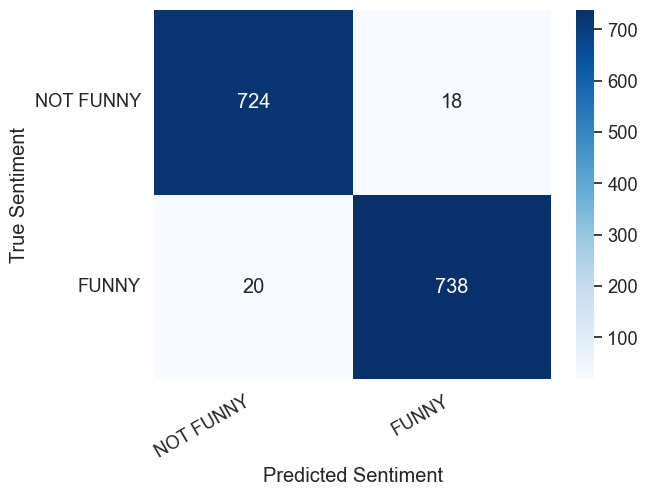

In [73]:
y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)
class_names = ['FUNNY','NOT FUNNY']


type(y_pred)
y_pred = np.array(y_pred)
y_test = np.array(y_test)
print(classification_report(y_test, y_pred, target_names=class_names))
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)


In [74]:
review_text = "What do you call a turtle without its shell? dead.'"
encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True,
                                       truncation=True, return_tensors='pt')
input_ids = encoded_review['input_ids'].to(device)
attention_mask=encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_,prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: What do you call a turtle without its shell? dead.'
Sentiment  : FUNNY
